In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
import pretrainedmodels

In [14]:
PATH=Path('data/')

In [15]:
src_size=array([150,210]);src_size

array([150, 210])

In [16]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [17]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [18]:
data

ImageDataBunch;

Train: LabelList (9989 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (2497 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
3,2,1,2,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [19]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [20]:
def model_f(pretrained=True, **kwargs):
    return pretrainedmodels.__dict__['resnext101_32x4d'](num_classes=1000, pretrained='imagenet')

def getLearner(data):
    learn1 = cnn_learner(data, model_f, metrics=error_rate)
    return learn1

In [21]:
learn=getLearner(data)

In [22]:
from torch import nn
weights=[0.35,0.1,0.1,0.1,0.35]
class_weights=torch.FloatTensor(weights).cuda()
learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)
#learn.loss_func=CrossEntropyFlat(weight=class_weights)

In [13]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


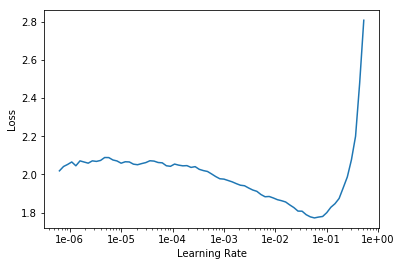

In [14]:
learn.recorder.plot()

In [15]:
learn.loss_func

CrossEntropyLoss()

epoch,train_loss,valid_loss,error_rate,time
0,1.218404,0.945278,0.434521,00:30
1,0.948137,0.822717,0.392871,00:21
2,0.817141,0.699667,0.322387,00:21
3,0.709885,0.593343,0.230677,00:34
4,0.613010,0.527243,0.223869,00:36
5,0.519432,0.476111,0.195835,00:36
6,0.486964,0.400089,0.182219,00:37
7,0.429629,0.373123,0.148979,00:36
8,0.401423,0.387523,0.134962,00:37
9,0.391422,0.375875,0.146175,00:36


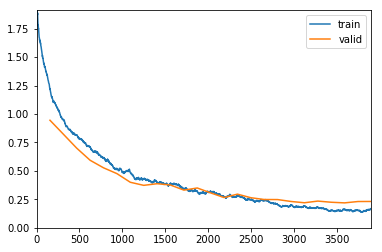

In [23]:
learn.fit_one_cycle(25,slice(1e-2),callbacks=ShowGraph(learn),wd=1e-1)

In [19]:
learn.save('Grey_inc-Fresh_Resnext101-stg1')

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


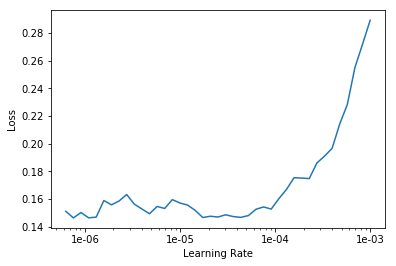

In [25]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.149045,0.223871,0.071286,00:32
1,0.155018,0.220000,0.073288,00:32
2,0.147350,0.219899,0.073288,00:32
3,0.142864,0.215408,0.069684,00:32
4,0.116273,0.212920,0.070084,00:32
5,0.123936,0.206859,0.067681,00:32
6,0.128873,0.215902,0.068883,00:32
7,0.125593,0.204530,0.063676,00:32


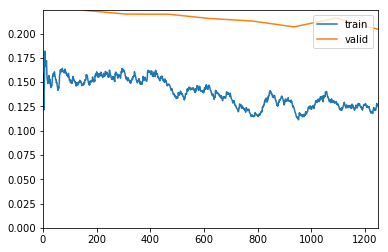

In [26]:
lr=5e-6
learn.fit_one_cycle(8,slice(lr,5e-5),callbacks=ShowGraph(learn),wd=1e-2)

In [23]:
learn.save('Grey_incl-Fresh_ResNEXT101-stg2-wts')

In [11]:
learn.load('Grey_incl-Fresh_ResNEXT101-stg2-wts')

PicklingError: Can't pickle <function <lambda> at 0x7f3deaadf840>: attribute lookup <lambda> on pretrainedmodels.models.resnext_features.resnext101_32x4d_features failed

In [27]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [28]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


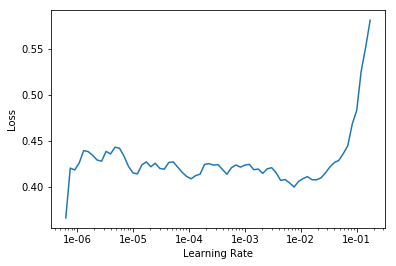

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.482500,0.358552,0.120144,00:49
1,0.356777,0.252325,0.087705,00:48
2,0.284769,0.204305,0.068883,00:48
3,0.235558,0.165894,0.054866,00:48
4,0.210488,0.144540,0.053264,00:48
5,0.173441,0.130950,0.044053,00:48
6,0.154274,0.120861,0.041650,00:48
7,0.148773,0.108872,0.035643,00:48
8,0.136608,0.104022,0.033640,00:48
9,0.120265,0.102244,0.032038,00:48


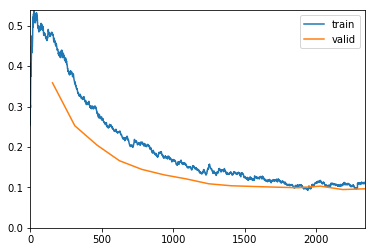

In [30]:
lr=1e-3
learn.fit_one_cycle(15,slice(lr),callbacks=ShowGraph(learn),wd=1e-2)

In [28]:
learn.save('Grey-incl-Fresh_resnext101-stg3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


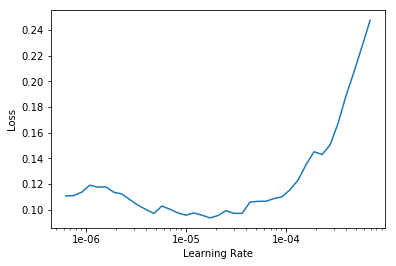

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.117392,0.101333,0.032038,01:10
1,0.107329,0.091796,0.032439,01:09
2,0.091149,0.086148,0.026432,01:10
3,0.092641,0.083720,0.028034,01:09


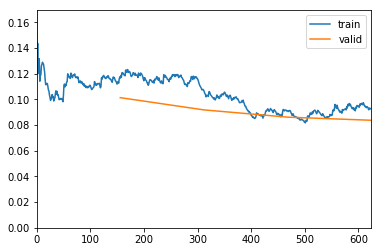

In [32]:
lr=4e-6
learn.fit_one_cycle(4,slice(lr,4e-5),callbacks=ShowGraph(learn),wd=1e-2)

In [32]:
learn.save('Grey-incl-Fresh_resnext101-stg4')

In [33]:
intept=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

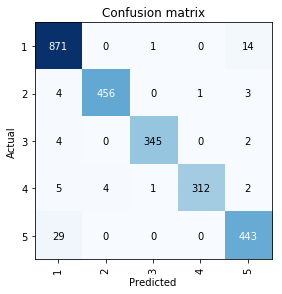

In [34]:
intept.plot_confusion_matrix()

In [35]:
intept.most_confused()

[(5, 1, 39),
 (1, 5, 18),
 (2, 1, 5),
 (1, 2, 2),
 (2, 5, 2),
 (3, 5, 2),
 (4, 5, 2),
 (4, 2, 1),
 (5, 2, 1)]

In [36]:
#intept.plot_top_losses(25,heatmap=False)

In [35]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnext101-fresh-noval-cls.csv',index=False)

### Try with duplicated class of 5

In [8]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new_dup.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [9]:
learn=getLearner(data)

In [8]:
data

ImageDataBunch;

Train: LabelList (10960 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,2,3,4,1
Path: data;

Valid: LabelList (2740 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
3,3,2,1,2
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [10]:
learn.data

ImageDataBunch;

Train: LabelList (13700 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


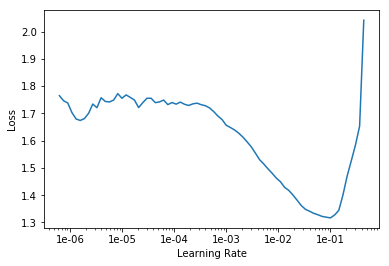

In [40]:
lr_find(learn)
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(30,slice(1e-2),callbacks=ShowGraph(learn),wd=1e-1)

In [42]:
learn.save('Dup-Grey-incl-Fresh_resnext101-stg1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


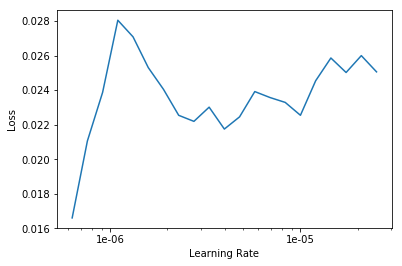

In [43]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.019055,0.043959,0.013616,01:06
1,0.019682,0.045326,0.013616,01:05
2,0.019487,0.043791,0.013616,01:05
3,0.020252,0.044876,0.014017,01:05
4,0.020117,0.045721,0.013616,01:05
5,0.021545,0.044595,0.014417,01:06


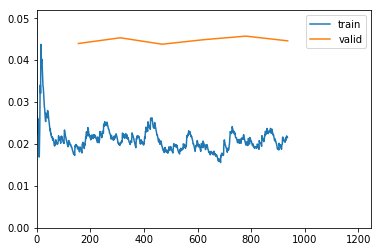

KeyboardInterrupt: 

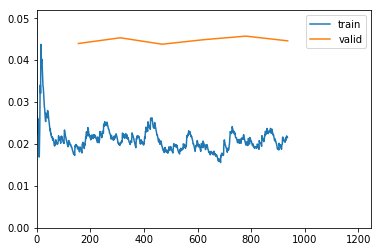

In [44]:
learn.fit_one_cycle(8,slice(1e-7),callbacks=ShowGraph(learn),wd=1e-2)

In [15]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new_dup.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [16]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


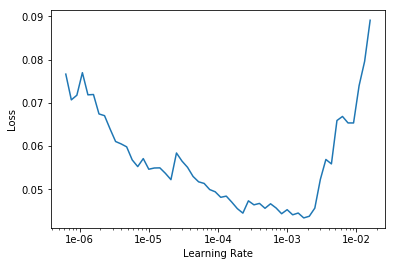

In [52]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(15,slice(2e-4),wd=1e-2,callbacks=ShowGraph(learn))

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


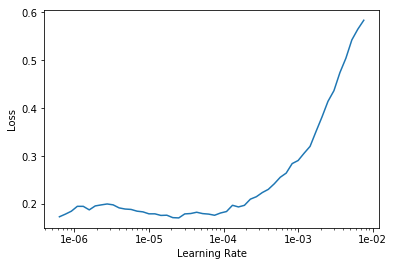

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(18,slice(2e-6,2e-4),wd=1e-2,callbacks=ShowGraph(learn))

In [20]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnext101-fresh-forged-noval.csv',index=False)